In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from concentrationMetrics import Index

In [2]:
gdppc = pd.read_csv("data/API_NY.GDP.PCAP.KD_DS2_en_csv_v2_2252313.csv", skiprows=4).drop(
    columns=["Country Name", "Indicator Name", "Indicator Code", "Unnamed: 65"]
).melt(id_vars="Country Code",var_name='year', value_name='gdppc').dropna().rename(columns={'Country Code':'region'})
gdppc['year'] = gdppc.year.astype(int)
gdppc.head()

,region,year,gdppc
7,ARG,1960,5642.765138
11,AUS,1960,19378.325276
12,AUT,1960,13031.031769
14,BDI,1960,213.396881
15,BEL,1960,13021.652323


## Load region-product data

In [3]:
trade = pd.read_parquet('data/cleaned.parquet')
trade.head()

,year,region,prod,export,regionsum,prodsum,yearsum,rca,binrca,pivec_p,pivec_m,pivec_c,pci,pci_m,pci_p,pci_c,pcil_m,pcil_p,pcil_c
0,1962,ABW,001,0.000000,0.000000e+00,6.782654e+08,1.234760e+11,0.000000,0,0.008395,0.002745,0.003898,-0.058055,-2.307477,-0.919122,-1.095074,-0.006335,-0.007716,-0.004269
1,1962,AFG,001,0.000000,8.181017e+07,6.782654e+08,1.234760e+11,0.000000,0,0.008395,0.002745,0.003898,-0.058055,-2.307477,-0.919122,-1.095074,-0.006335,-0.007716,-0.004269
2,1962,AGO,001,9682.848633,1.311828e+08,6.782654e+08,1.234760e+11,0.013437,0,0.008395,0.002745,0.003898,-0.058055,-2.307477,-0.919122,-1.095074,-0.006335,-0.007716,-0.004269
3,1962,AIA,001,0.000000,0.000000e+00,6.782654e+08,1.234760e+11,0.000000,0,0.008395,0.002745,0.003898,-0.058055,-2.307477,-0.919122,-1.095074,-0.006335,-0.007716,-0.004269
4,1962,ALB,001,0.000000,2.301677e+06,6.782654e+08,1.234760e+11,0.000000,0,0.008395,0.002745,0.003898,-0.058055,-2.307477,-0.919122,-1.095074,-0.006335,-0.007716,-0.004269


## transform and calculate metrics

In [4]:
R0 = 0.115

In [5]:
## transform with R0 and project
df = trade.assign(llrca = np.log(1+trade.rca/R0)/np.log(1+1/R0))
df['bin'] = df.export>0
df['avgrca_part_p'] = df.llrca*df.pivec_p
df['avgrca_part_m'] = df.llrca*df.pivec_m
df['avgrca_part_c'] = df.llrca*df.pivec_c
df['avgrca_p'] = df.groupby(['year','region'])['avgrca_part_p'].transform(sum)
df['avgrca_m'] = df.groupby(['year','region'])['avgrca_part_m'].transform(sum)
df['avgrca_c'] = df.groupby(['year','region'])['avgrca_part_c'].transform(sum)
df['diversity'] = df.groupby(['year','region'])['binrca'].transform(sum)
df.avgrca_p.describe()

count    3.335355e+06
mean     3.586094e-01
std      2.806920e-01
min      0.000000e+00
25%      1.172252e-01
50%      3.212149e-01
75%      5.881455e-01
max      1.005534e+00
Name: avgrca_p, dtype: float64

In [6]:
df['rct_p'] = np.where(df.avgrca_p>0,df.llrca/df.avgrca_p,0)
df['rct_m'] = np.where(df.avgrca_m>0,df.llrca/df.avgrca_m,0)
df['rct_c'] = np.where(df.avgrca_c>0,df.llrca/df.avgrca_c,0)
df['rct_demean_p'] = df.rct_p-df.groupby('prod').rct_p.transform('mean')
df['rct_demean_m'] = df.rct_m-df.groupby('prod').rct_m.transform('mean')
df['rct_demean_c'] = df.rct_c-df.groupby('prod').rct_c.transform('mean')
df['proj_p'] = np.where(df.avgrca_p>0, df.pci_p * df.llrca * df.pivec_p / df.avgrca_p,0)
df['proj_m'] = np.where(df.avgrca_m>0, df.pci_m * df.llrca * df.pivec_m / df.avgrca_m,0)
df['proj_c'] = np.where(df.avgrca_c>0, df.pci_c * df.llrca * df.pivec_c / df.avgrca_c,0)
df['eci_part'] = np.where(df.diversity>0,df.pci * df.binrca/df.diversity,0)
df.head()

,year,region,prod,export,regionsum,prodsum,yearsum,rca,binrca,pivec_p,...,rct_p,rct_m,rct_c,rct_demean_p,rct_demean_m,rct_demean_c,proj_p,proj_m,proj_c,eci_part
0,1962,ABW,001,0.000000,0.000000e+00,6.782654e+08,1.234760e+11,0.000000,0,0.008395,...,0.000000,0.000000,0.000000,-0.766895,-1.179861,-1.066510,0.000000,0.000000,0.000000,0.0
1,1962,AFG,001,0.000000,8.181017e+07,6.782654e+08,1.234760e+11,0.000000,0,0.008395,...,0.000000,0.000000,0.000000,-0.766895,-1.179861,-1.066510,-0.000000,-0.000000,-0.000000,-0.0
2,1962,AGO,001,9682.848633,1.311828e+08,6.782654e+08,1.234760e+11,0.013437,0,0.008395,...,0.117628,0.268855,0.202484,-0.649267,-0.911006,-0.864026,-0.000908,-0.001703,-0.000864,-0.0
3,1962,AIA,001,0.000000,0.000000e+00,6.782654e+08,1.234760e+11,0.000000,0,0.008395,...,0.000000,0.000000,0.000000,-0.766895,-1.179861,-1.066510,0.000000,0.000000,0.000000,0.0
4,1962,ALB,001,0.000000,2.301677e+06,6.782654e+08,1.234760e+11,0.000000,0,0.008395,...,0.000000,0.000000,0.000000,-0.766895,-1.179861,-1.066510,-0.000000,-0.000000,-0.000000,-0.0


In [7]:
cntryagg = df.groupby(['year','region'])[['avgrca_part_p','avgrca_part_m','avgrca_part_c','proj_p','proj_m','proj_c','eci_part','bin']].sum().reset_index().rename(columns={'avgrca_part_p':'avgrca_p','avgrca_part_m':'avgrca_m','avgrca_part_c':'avgrca_c','eci_part':'eci'})
cntryagg = cntryagg.merge(gdppc,how='left')
cntryagg.head()

,year,region,avgrca_p,avgrca_m,avgrca_c,proj_p,proj_m,proj_c,eci,bin,gdppc
0,1962,ABW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,NaN
1,1962,AFG,0.229441,0.075256,0.101934,-1.007255,-1.725521,-1.162990,-0.067015,39,NaN
2,1962,AGO,0.413560,0.180938,0.240246,-0.870960,-1.279847,-0.896124,-0.060397,134,NaN
3,1962,AIA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,NaN
4,1962,ALB,0.211957,0.075734,0.103582,-0.996652,-1.301794,-0.791606,-0.079119,24,NaN


In [8]:
cntryagg.year.nunique(),cntryagg.region.nunique()

(57, 249)

## plot figures in main text and SI

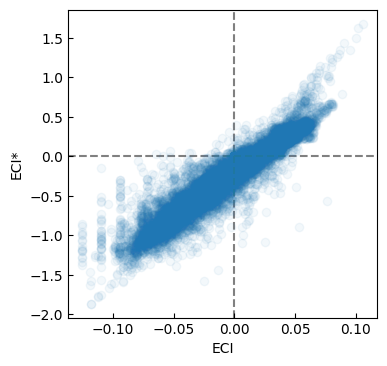

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
plt.axvline(x=0, color='grey', linestyle='--',zorder=0)
plt.axhline(y=0, color='grey', linestyle='--',zorder=0)
ax.scatter(cntryagg.eci,cntryagg.proj_p,alpha=0.05,zorder=5)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
#ax.set_xlim([-1,1])
#ax.set_ylim([-1,1])
ax.set_aspect(0.065)
plt.xlabel("ECI")
plt.ylabel("ECI*")
plt.savefig("fig4.pdf", bbox_inches = 'tight', pad_inches = 0.05)

In [10]:
pcidf = trade.groupby(['prod'])[['pci','pci_p','pci_m','pci_c']].median().reset_index()
pcidf.head()

,prod,pci,pci_p,pci_m,pci_c
0,001,-0.058055,-0.919122,-2.307477,-1.095074
1,011,-0.047274,-0.748433,-1.504462,-1.079574
2,012,0.004117,0.065186,-0.488577,-0.492125
3,014,-0.030579,-0.484118,-1.760025,-1.132278
4,022,0.045869,0.726199,0.118942,-0.481562


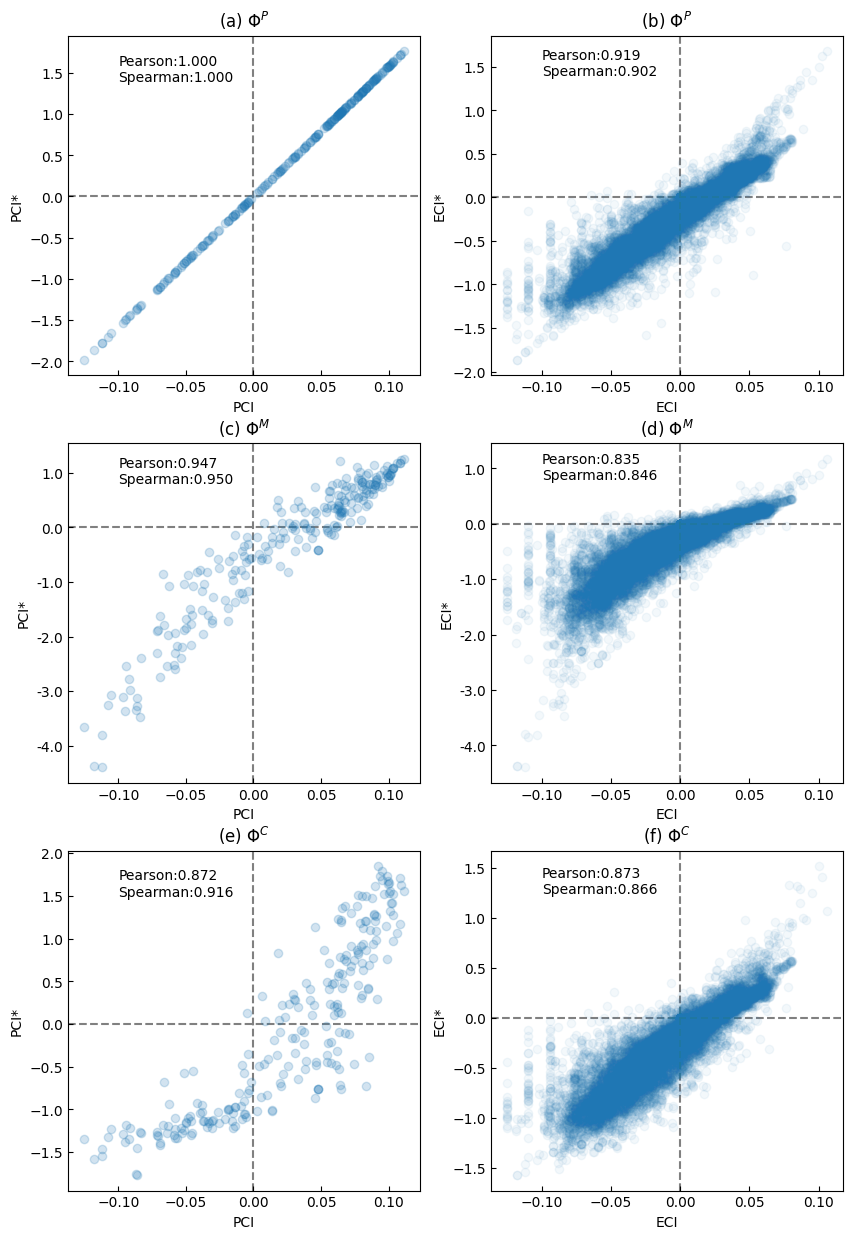

In [11]:
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr
fig, ax = plt.subplots(3,2,figsize=(10,15))

ax[0,0].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[0,0].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[0,0].tick_params(axis="y",direction="in")
ax[0,0].tick_params(axis="x",direction="in")
ax[0,0].scatter(pcidf.pci,pcidf.pci_p,alpha=0.2,zorder=5)
ax[0,0].set_xlabel('PCI')
ax[0,0].set_ylabel('PCI*')
ax[0,0].text(-0.1,1.4,f'Pearson:{np.corrcoef(pcidf.pci,pcidf.pci)[0,1]:.3f}\nSpearman:{spearmanr(pcidf.pci,pcidf.pci)[0]:.3f}')
ax[0,0].set_title(r'(a) $\Phi^P$')

ax[0,1].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[0,1].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[0,1].tick_params(axis="y",direction="in")
ax[0,1].tick_params(axis="x",direction="in")
ax[0,1].scatter(cntryagg.eci,cntryagg.proj_p,alpha=0.05,zorder=5)
ax[0,1].set_xlabel('ECI')
ax[0,1].set_ylabel('ECI*')
ax[0,1].text(-0.1,1.4,f'Pearson:{np.corrcoef(cntryagg.eci,cntryagg.proj_p)[0,1]:.3f}\nSpearman:{spearmanr(cntryagg.eci,cntryagg.proj_p)[0]:.3f}')
ax[0,1].set_title(r'(b) $\Phi^P$')

ax[1,0].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[1,0].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[1,0].tick_params(axis="y",direction="in")
ax[1,0].tick_params(axis="x",direction="in")
ax[1,0].scatter(pcidf.pci,pcidf.pci_m,alpha=0.2,zorder=5)
ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1,0].set_xlabel('PCI')
ax[1,0].set_ylabel('PCI*')
ax[1,0].text(-0.1,0.8,f'Pearson:{np.corrcoef(pcidf.pci_m,pcidf.pci)[0,1]:.3f}\nSpearman:{spearmanr(pcidf.pci_m,pcidf.pci)[0]:.3f}')
ax[1,0].set_title(r'(c) $\Phi^M$')


ax[1,1].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[1,1].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[1,1].tick_params(axis="y",direction="in")
ax[1,1].tick_params(axis="x",direction="in")
ax[1,1].scatter(cntryagg.eci,cntryagg.proj_m,alpha=0.05,zorder=5)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1,1].set_xlabel('ECI')
ax[1,1].set_ylabel('ECI*')
ax[1,1].text(-0.1,0.8,f'Pearson:{np.corrcoef(cntryagg.eci,cntryagg.proj_m)[0,1]:.3f}\nSpearman:{spearmanr(cntryagg.eci,cntryagg.proj_m)[0]:.3f}')
ax[1,1].set_title(r'(d) $\Phi^M$')

ax[2,0].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[2,0].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[2,0].tick_params(axis="y",direction="in")
ax[2,0].tick_params(axis="x",direction="in")
ax[2,0].scatter(pcidf.pci,pcidf.pci_c,alpha=0.2,zorder=5)
ax[2,0].set_xlabel('PCI')
ax[2,0].set_ylabel('PCI*')
ax[2,0].text(-0.1,1.5,f'Pearson:{np.corrcoef(pcidf.pci_c,pcidf.pci)[0,1]:.3f}\nSpearman:{spearmanr(pcidf.pci_c,pcidf.pci)[0]:.3f}')
ax[2,0].set_title(r'(e) $\Phi^C$')


ax[2,1].axvline(x=0, color='grey', linestyle='--',zorder=0)
ax[2,1].axhline(y=0, color='grey', linestyle='--',zorder=0)
ax[2,1].tick_params(axis="y",direction="in")
ax[2,1].tick_params(axis="x",direction="in")
ax[2,1].scatter(cntryagg.eci,cntryagg.proj_c,alpha=0.05,zorder=5)
ax[2,1].set_xlabel('ECI')
ax[2,1].set_ylabel('ECI*')
ax[2,1].text(-0.1,1.25,f'Pearson:{np.corrcoef(cntryagg.eci,cntryagg.proj_c)[0,1]:.3f}\nSpearman:{spearmanr(cntryagg.eci,cntryagg.proj_c)[0]:.3f}')
ax[2,1].set_title(r'(f) $\Phi^C$')

plt.savefig("figs1.pdf", bbox_inches = 'tight', pad_inches = 0.05)

## export dataset to analyze in matlab

In [12]:
cntryagg2 = cntryagg[cntryagg.bin>0].assign(ry=cntryagg.region+cntryagg.year.astype(str)).sort_values('ry').reset_index(drop=True)
cntryagg2.shape

(11544, 12)

In [13]:
sio.savemat('data/cntryyear_pmc.mat', {'struct1':cntryagg2[['year', 'region','ry', 'avgrca_p','avgrca_m','avgrca_c', 'proj_p', 'proj_m', 'proj_c', 'eci','bin', 'gdppc']].rename(columns={'ry':'cntryyear','avgrca_p':'zct_p', 'proj_p':'ecistar_p','avgrca_m':'zct_m', 'proj_m':'ecistar_m','avgrca_c':'zct_c', 'proj_c':'ecistar_c','bin':'bindiversity'}).to_dict("list")})

In [14]:
df2=df.assign(ry=df.region+df.year.astype(str))
df2['bincounts'] = df2.groupby('ry')['bin'].transform(sum)
df2 = df2[df2.bincounts>0]
df2.columns

Index(['year', 'region', 'prod', 'export', 'regionsum', 'prodsum', 'yearsum',
       'rca', 'binrca', 'pivec_p', 'pivec_m', 'pivec_c', 'pci', 'pci_m',
       'pci_p', 'pci_c', 'pcil_m', 'pcil_p', 'pcil_c', 'llrca', 'bin',
       'avgrca_part_p', 'avgrca_part_m', 'avgrca_part_c', 'avgrca_p',
       'avgrca_m', 'avgrca_c', 'diversity', 'rct_p', 'rct_m', 'rct_c',
       'rct_demean_p', 'rct_demean_m', 'rct_demean_c', 'proj_p', 'proj_m',
       'proj_c', 'eci_part', 'ry', 'bincounts'],
      dtype='object')

In [15]:
Rcpt = df2.pivot(index="prod", columns="ry", values='llrca').fillna(0)#.values
Rcpt.shape

(235, 11544)

In [16]:
sio.savemat('data/rcptcolumns.mat',{'cntryyear':Rcpt.columns.values})

In [ ]:
zct = df2.pivot(index="prod", columns="ry", values='avgrca_p').fillna(0).values[0,:]
zct.shape

In [ ]:
ecistar = df2.pivot(index="prod", columns="ry", values='proj_p').values.sum(axis=0)
ecistar.shape

In [ ]:
pcistar = df2.pivot(index="prod", columns="ry", values='pci_p').fillna(0).values[:,0]
pcistar.shape

In [ ]:
sio.savemat('data/fig5b.mat',{'Rcpt':Rcpt,'zct':zct,'ecistar':ecistar,'pcistar':pcistar})

In [ ]:
df['share'] = np.where(df.regionsum>0,df.export/df.regionsum,0)

In [ ]:
sharemat = df.assign(ry=df.region+df.year.astype(str)).pivot(columns='prod',index='ry',values='share').fillna(0)
sharemat.shape

In [ ]:
rygini = Index(data=sharemat.values+1e-12,index='gini').results
ryshannon = Index(data=sharemat.values+1e-12,index='shannon').results
ryhhi = Index(data=sharemat.values+1e-12,index='hhi').results
len(rygini),len(ryshannon),len(ryhhi)

In [ ]:
cntrylabel = pd.read_csv('data/cntrylabel2.tsv',sep='\t',dtype='string')
cntrylabel.head()

In [ ]:
cntryagg2 = cntryagg[cntryagg.bin>0].assign(ry=cntryagg.region+cntryagg.year.astype(str)).sort_values('ry').reset_index(drop=True)
cntryagg2.head()

In [ ]:
cntryagg2 = cntryagg2.merge(
    pd.DataFrame.from_dict(
        {"gini": rygini, "shannon": ryshannon, "hhi": ryhhi, "ry": sharemat.index}
    ),
    how="left",
).merge(cntrylabel, how="left")
cntryagg2.head()

In [ ]:
sio.savemat('data/cntryyear_pmc.mat', {'struct1':cntryagg2[['year', 'region','ry', 'avgrca_p','avgrca_m','avgrca_c', 'proj_p', 'proj_m', 'proj_c', 'eci','bin', 'gdppc','gini','shannon','hhi','label']].rename(columns={'ry':'cntryyear','avgrca_p':'zct_p', 'proj_p':'ecistar_p','avgrca_m':'zct_m', 'proj_m':'ecistar_m','avgrca_c':'zct_c', 'proj_c':'ecistar_c','bin':'bindiversity'}).to_dict("list")})